![header](https://i.imgur.com/I4ake6d.jpg)

# COPERNICUS MARINE IN SITU ARCTIC TRAINING (5/5)

<div style="text-align: right"><i> 13-05-Part-five-out-of-five </i></div>

***
# ARC `NRT` product/dataset: managing files (hfradars)

***
**General Note 1**: Execute each cell through the <button class="btn btn-default btn-xs"><i class="icon-play fa fa-play"></i></button> button from the top MENU (or keyboard shortcut `Shift` + `Enter`).<br>
<br>
**General Note 2**: If, for any reason, the kernel is not working anymore, in the top MENU, click on the <button class="btn btn-default btn-xs"><i class="fa fa-repeat icon-repeat"></i></button> button. Then, in the top MENU, click on "Cell" and select "Run All Above Selected Cell".<br>
***

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc">
    <ul class="toc-item">
        <li><span><a href="#1.-Introduction" data-toc-modified-id="1.-Introduction">1. Introduction</a></span></li>
        <li>
            <span><a href="#2.-Setup" data-toc-modified-id="2.-Setup">2. Setup</a></span>
            <ul>
                <li><span><a href="#2.1.-Python-packages" data-toc-modified-id="2.1.-Python-packages">2.1. Python packages</a></span></li>
                <li><span><a href="#2.2.-Auxiliary-functions" data-toc-modified-id="2.2.-Auxiliary-functions">2.2. Auxiliary functions</a></span></li>
            </ul>
        </li>
        <li><span><a href="#3.-High-Frequency-radars-(HF)-data" data-toc-modified-id="3.-High-Frequency-radars-(HF)-data">3. High Frequency radars (HF) data</a></span>
            <ul>
                <li><span><a href="#3.1.-Reading-the-file" data-toc-modified-id="3.1.-Reading-the-file">3.1. Reading the file</a></span></li>
                <li><span><a href="#3.2.-Data-visualization" data-toc-modified-id="3.2.-Data-visualization">3.2. Data visualization</a></span>
                    <ul>
                        <li><span><a href="#3.2.1.-Source-antennas" data-toc-modified-id="3.2.1.-Source-antennas">3.2.1. Source antennas</a></span></li>
                        <li><span><a href="#3.2.2.-Spatial-coverage" data-toc-modified-id="3.2.2.-Spatial-coverage">3.2.2. Spatial coverage</a></span></li>
                        <li><span><a href="#3.2.3.-Velocity-vectors" data-toc-modified-id="3.2.3.-Velocity-vectors">3.2.3. Velocity vectors</a></span></li>
                        <li><span><a href="#3.2.4.-Platform-performance" data-toc-modified-id="3.2.4.-Platform-performance">3.2.4. Platform performance</a></span></li>
                    </ul>
                </li>
           </ul>
        </li>
        <li><span><a href="#4.-Wrap-up" data-toc-modified-id="4.-Wrap-up">4. Wrap-up</a></span></li>
    </ul>
</div>

***

## 1. Introduction
[Go back to the "Table of Contents"](#Table-of-Contents)

According to the notebook [13-01-NearRealTtime-product-collections-overview.ipynb](13-01-NearRealTtime-product-collections-overview.ipynb), one of the data source types available is High Frequency radars. Please use the notebook [13-02-NearRealTtime-product-subsetting-download](13-02-NearRealTtime-product-subsetting-download.ipynb) to download some files from High Frequency radars ('HF' data type) and let's check the data. If you wanna skip the downloading part you can use the netCDF files available `/data/nc_files/HF` instead.  

## 2. Setup
[Go back to the "Table of Contents"](#Table-of-Contents)

### 2.1. Python packages

For the notebook to properly run we need to first load the next packages available from the Jupyter Notebook Ecosystem. Please run the `next cell`:

In [1]:
import warnings
warnings.filterwarnings("ignore")

import IPython
import datetime
import os
import numpy as np
import pandas as pd
import xarray
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython.display import YouTubeVideo
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.io.img_tiles as cimgt
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon
import collections
%matplotlib inline

<div class="alert alert-block alert-warning">
<b>WARNING</b>
    
***  
If any of them raises any error it means you need to install the module first. For doing so please:
1. Open a new cell in the notebook
2. Run <i>`!conda install packageName --yes`</i> or <i>`!conda install -c conda-forge packageName --yes`</i> or <i>`!pip install packageName`</i>
3. Import again!
<br><br>
Example: <i>how-to-solve import error for json2html module </i>

![region.png](img/errorImporting.gif)

### 2.2. Auxiliary functions

In [2]:
def getAuxiliaryCoordinates(ds):
    result = {'X':'RNGE','Y': 'BEAR'}
    if 'RNGE' not in ds.variables:
        result = {'X':'LONGITUDE','Y': 'LATITUDE'}
    return result

In [3]:
def getSourceAntennas(ds):
    data = {'antennas':[] ,'bbox':[]}
    lats,lons = [],[]
    try:
        for name,lat,lon in zip(ds['SCDT'][0,:].astype('str').data,ds['SLTT'][0,:].data,ds['SLNT'][0,:].data):
            if name not in ["",'nan'] and type(name)!= float:
                data['antennas'].append({'name': name, 'lat': float(str(lat)[:6]), 'lon': float(str(lon)[:6])})
                lats.append(lat)
                lons.append(lon)
        data['bbox'] = [min(lons),max(lons),min(lats),max(lats)]
    except Exception as e:
        data = None
        print('An error ocurred when checking antennas')
        print(e)
    return data

In [4]:
def getLastCoverage(ds,flags):
    data = None
    result = getAuxiliaryCoordinates(ds)
    Y,X = ds[result['Y']], ds[result['X']]
    U,QCflag = ds['EWCT'], ds['QCflag']
    try:
        Y_ok, X_ok = [],[]
        for j in range(0, len(Y)):
            for i in range(0, len(X)):
                qc = QCflag[-1,0,j,i]
                if qc in flags:
                    val =  U[-1,0,j,i]
                    if np.isnan(val) == False:
                        if 'RNGE' in ds.variables:
                            Y_ok.append(ds['LATITUDE'][j,i].data)
                            X_ok.append(ds['LONGITUDE'][j,i].data)
                        else:
                            Y_ok.append(ds['LATITUDE'][j].data)
                            X_ok.append(ds['LONGITUDE'][i].data)
        points = [[x,y] for y,x in zip(Y_ok, X_ok)]
        if len(points) != 0:
            vertices = ConvexHull(points).vertices
            coords = [[float(str(points[p][0])),float(str(points[p][1]))] for p in vertices]
            data = Polygon(coords)
        else:
            print('No coverage could be computed considering those flags.')
    except Exception as e:
        print(e)
        print('An error ocurred when computing coverage.')
    return data

In [5]:
def getPerformance(ds, flags, daysBack):
    reference = datetime.datetime.strptime(ds.time_coverage_end.split('T')[0], '%Y-%m-%d')
    start_date = reference - datetime.timedelta(daysBack)
    closerval = ds['TIME'].sel(TIME=start_date, method="nearest")
    idx_start = ds['TIME'].values.tolist().index(closerval)
    data = []
    try:
        QCflag = ds['QCflag'][idx_start:,0]
        result, array = {}, []
        good_qc = np.isin(QCflag, flags)
        percentage_factor = 100/np.shape(QCflag)[0]
        percentage_good_qc = np.count_nonzero(good_qc, axis=0)*percentage_factor
        array = percentage_good_qc.flatten()
        nozeros = [item for item in array if item > 0]
        if len(nozeros) != 0:
            for i in range(1, 100, 1):
                subset = [val for val in array if val >= i]
                result[i] = (len(subset)*100)/len(nozeros)
            data = list(result.values())
        else:
            print('No performance metric could be computed with the selected flags')
    except Exception as e:
        print('An error ocurred when computing performance')
    return data

## 3. High Frequency radars (HF) data
[Go back to the "Table of Contents"](#Table-of-Contents)

High Frequency (HF) Radars are land-based remote sensing instruments (antennas) located near the coastline that provide maps of currents. An HF radar system is composed by two or more antennas. Data coming from a single Antenna is known as 'Radial' ('RV' file type) whereas the resulting combination of the radials is known as 'Total' ('TV' file type).

<br>Here a self explanatory video from The COMET Program/MetEd:  `run the next cell`

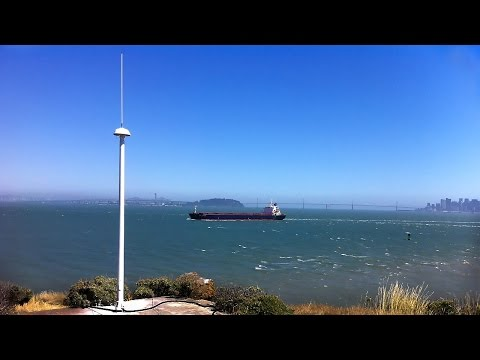

In [6]:
YouTubeVideo('Ii83ob2cwhE', width="100%", height=500, end=148)

Let's see the data of one of the available HF Radars in the ARC Seas.

### 3.1. Reading the file

`Run the next cell` to see the HF Radar files already available in the /data folder:

In [7]:
dir_HF = os.path.join(os.getcwd(),'data','nc_files','HF') 
os.listdir(dir_HF)

['GL_TV_HF_HFR-DeltaEbro-Total_202010.nc',
 'GL_RV_HF_HFR-Skagerrak-JOMF.nc',
 'GL_RV_HF_HFR-Finnmark-FRUH.nc',
 'GL_RV_HF_HFR-Skagerrak-TORU.nc']

`Set one` of the above available `file name` and `run the next cells`:

In [8]:
file = 'GL_RV_HF_HFR-Finnmark-FRUH.nc'
path = os.path.join(dir_HF, file)

In [9]:
ds = xarray.open_dataset(path)
ds.close()
ds

<xarray.Dataset>
Dimensions:           (BEAR: 180, DEPTH: 1, MAXINST: 1, MAXSITE: 1, REFMAX: 1, RNGE: 20, TIME: 1201)
Coordinates:
  * TIME              (TIME) object 2020-09-21 00:59:59.999997 ... 2020-11-10...
  * BEAR              (BEAR) float32 1.0 3.0 5.0 7.0 ... 353.0 355.0 357.0 359.0
  * RNGE              (RNGE) float32 0.0 5.097 10.19 15.29 ... 86.64 91.74 96.84
    DEPH              (DEPTH) float32 ...
    LATITUDE          (BEAR, RNGE) float32 ...
    LONGITUDE         (BEAR, RNGE) float32 ...
Dimensions without coordinates: DEPTH, MAXINST, MAXSITE, REFMAX
Data variables:
    crs               int16 ...
    SDN_CRUISE        (TIME) |S12 ...
    SDN_STATION       (TIME) |S17 ...
    SDN_LOCAL_CDI_ID  (TIME) |S38 ...
    SDN_EDMO_CODE     (TIME, MAXINST) int16 ...
    SDN_REFERENCES    (TIME) |S10 ...
    SDN_XLINK         (TIME, REFMAX) |S71 ...
    RDVA              (TIME, DEPTH, BEAR, RNGE) float32 ...
    DRVA              (TIME, DEPTH, BEAR, RNGE) float64 ...
    EWCT              (TIME, DEPTH, BEAR, RNGE) float32 ...
    NSCT              (TIME, DEPTH, BEAR, RNGE) float32 ...
    ESPC              (TIME, DEPTH, BEAR, RNGE) float32 ...
    ETMP              (TIME, DEPTH, BEAR, RNGE) float32 ...
    MAXV              (TIME, DEPTH, BEAR, RNGE) float32 ...
    MINV              (TIME, DEPTH, BEAR, RNGE) float32 ...
    ERSC              (TIME, DEPTH, BEAR, RNGE) float32 ...
    ERTC              (TIME, DEPTH, BEAR, RNGE) float32 ...
    XDST              (BEAR, RNGE) float64 ...
    YDST              (BEAR, RNGE) float64 ...
    SPRC              (TIME, DEPTH, BEAR, RNGE) float32 ...
    NARX              (TIME) float32 ...
    NATX              (TIME) float32 ...
    SLTR              (TIME, MAXSITE) float64 ...
    SLNR              (TIME, MAXSITE) float64 ...
    SLTT              (TIME, MAXSITE) float64 ...
    SLNT              (TIME, MAXSITE) float64 ...
    SCDR              (TIME, MAXSITE) object ...
    SCDT              (TIME, MAXSITE) object ...
    TIME_QC           (TIME) float32 ...
    POSITION_QC       (TIME, DEPTH, BEAR, RNGE) float32 ...
    DEPH_QC           (TIME) float32 ...
    QCflag            (TIME, DEPTH, BEAR, RNGE) float32 ...
    OWTR_QC           (TIME, DEPTH, BEAR, RNGE) float32 ...
    MDFL_QC           (TIME, DEPTH, BEAR, RNGE) float32 ...
    VART_QC           (TIME, DEPTH, BEAR, RNGE) float32 ...
    CSPD_QC           (TIME, DEPTH, BEAR, RNGE) float32 ...
    AVRB_QC           (TIME) float32 ...
    RDCT_QC           (TIME) float32 ...
Attributes:
    site_code:                       HFR-Finnmark
    data_mode:                       R
    DoA_estimation_method:           Direction Finding
    calibration_type:                APM
    last_calibration_date:           2016-10-18T00:00:00Z
    calibration_link:                avsluttet-sune.jensen@hi.no
    title:                           Near Real Time Surface Ocean Velocity by...
    summary:                         The data set consists of maps of radial ...
    source:                          coastal structure
    source_platform_category_code:   17
    institution:                     Norwegian Meteorological Institute
    institution_edmo_code:           1212
    data_assembly_center:            European HFR Node
    data_type:                       HF radar radial data
    feature_type:                    surface
    Conventions:                     CF-1.6 Jerico-Next-deliverable-D5.14 Cop...
    update_interval:                 void
    citation:                        These data were collected and made freel...
    distribution_statement:          These data follow Copernicus standards; ...
    publisher_name:                  European HFR Node
    publisher_url:                   http://eurogoos.eu/
    publisher_email:                 euhfrnode@azti.es
    license:                         HF radar sea surface current velocity da...
    acknowledgment:                  HFR-Finnmark Radar Network has been desi...
    date_cr

The above one is an overview of the content of the file: variables, dimensions, coordinates, global attributes...
<br>Let's list now the available variables: `run the next cell`

In [10]:
for var in ds.variables:
    try:
        print(var + ':' + ds[var].attrs['long_name'])
    except Exception as e:
        pass

TIME:Time
BEAR:Bearing away from instrument
RNGE:Range away from instrument
DEPH:Depth of measurement
LATITUDE:Latitude of each location
LONGITUDE:Longitude of each location
SDN_CRUISE:Grid grouping label
SDN_STATION:Grid label
SDN_LOCAL_CDI_ID:SeaDataCloud CDI identifier
SDN_EDMO_CODE:European Directory of Marine Organisations code for the CDI partner
SDN_REFERENCES:Usage metadata reference
SDN_XLINK:External resource linkages
RDVA:Radial Sea Water Velocity Away From Instrument
DRVA:Direction of Radial Vector Away From Instrument
EWCT:West-east current component
NSCT:South-north current component
ESPC:Radial Standard Deviation of Current Velocity over the Scatter Patch
ETMP:Radial Standard Deviation of Current Velocity over Coverage Period
MAXV:Radial Sea Water Velocity Away From Instrument Maximum
MINV:Radial Sea Water Velocity Away From Instrument Minimum
ERSC:Radial Sea Water Velocity Spatial Quality Count
ERTC:Radial Sea Water Velocity Temporal Quality Count
XDST:Eastward Distance

In In Situ TAC netCDFs all variables are linked to another called the same plus '_QC'. This 'twin' variable contains a quality flag for each value in the paired variable. `run the next cell` to check the flag values convention:

In [11]:
pd.DataFrame(data=ds['QCflag'].attrs['flag_values'],
             index=ds['QCflag'].attrs['flag_meanings'].split(' '), columns=['quality flag'])

,quality flag
no_qc_performed,0
good_data,1
probably_good_data,2
bad_data_that_are_potentially_correctable,3
bad_data,4
value_changed,5
not_used,6
nominal_value,7
interpolated_value,8
missing_value,9


Users are recommended to use only the data flagged as 1, they so called 'good data'.

### 3.2. Data visualization

[Go back to the "Table of Contents"](#Table-of-Contents)

#### 3.2.1. Source antennas

As it was exposed before, the source of the data reported by an HF Radar platform are the antennas. <br>Let's check the name and location of the ones that produced this file: `tun the next cell`

In [12]:
info = getSourceAntennas(ds)
info['antennas']

[{'name': 'FRUH', 'lat': 71.094, 'lon': 23.982}]

Let's see those on a map!: `run the next cell`

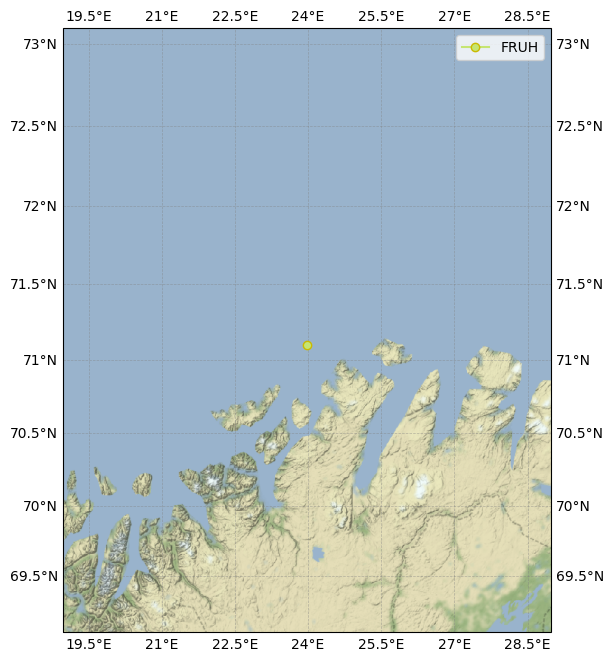

In [13]:
plt.figure(num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')
ax = plt.axes(projection=ccrs.Mercator())# Map projection
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--') #adding grid lines
for antenna in info['antennas']:
    plt.plot(antenna['lon'], antenna['lat'], color=np.random.rand(3,), markeredgecolor=np.random.rand(3,), marker='o',transform=ccrs.Geodetic(),label=antenna['name'])#add track line + profiler sampling points
ax.legend()#add legend
extent = [info['bbox'][0]-5,info['bbox'][1]+5,info['bbox'][2]-2,info['bbox'][3]+2] #minX,maxX,#minY,maxY
scale = np.ceil(-np.sqrt(2)*np.log(np.divide((extent[1]-extent[0])/2.0,350.0))) #zoom based on limits
tile_img = cimgt.StamenTerrain()
ax.add_image(tile_img,int(scale))#adding google tile
ax.set_extent(extent)#personalized limts

#uncomment next lines to save the figure
#figure_name = ds.id+'_track.png'
#plt.savefig(figure_name) 
plt.show()

#### 3.2.2. Spatial coverage

As stated before, the HF Radar platforms report maps of currents near the coastline. 
<br>Let's check the coverage of this maps: `run the next cells`

In [14]:
coverage = getLastCoverage(ds,[0,1,2,3,4,5,6,7,8,9])

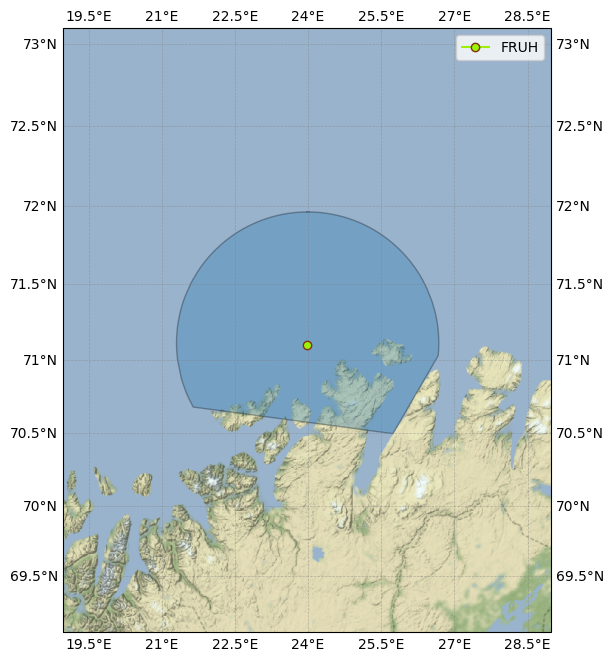

In [15]:
plt.figure(num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')
ax = plt.axes(projection=ccrs.Mercator())# Map projection
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--') #adding grid lines
for antenna in info['antennas']:
    plt.plot(antenna['lon'], antenna['lat'], color=np.random.rand(3,), markeredgecolor=np.random.rand(3,), marker='o',transform=ccrs.Geodetic(),label=antenna['name'])#add track line + profiler sampling points
ax.add_geometries([coverage], crs=cartopy.crs.PlateCarree(), alpha=0.3, edgecolor='k')
ax.legend()#add legend
extent = [info['bbox'][0]-5,info['bbox'][1]+5,info['bbox'][2]-2,info['bbox'][3]+2] #minX,maxX,#minY,maxY
scale = np.ceil(-np.sqrt(2)*np.log(np.divide((extent[1]-extent[0])/2.0,350.0))) #zoom based on limits
tile_img = cimgt.StamenTerrain()
ax.add_image(tile_img,int(scale))#adding google tile
ax.set_extent(extent)#personalized limts

#uncomment next lines to save the figure
#figure_name = ds.id+'_track.png'
#plt.savefig(figure_name) 
plt.show()

Let's be more strict with QC flags!:`run the next cells`

In [16]:
coverage = getLastCoverage(ds,[1,2])

No coverage could be computed considering those flags.


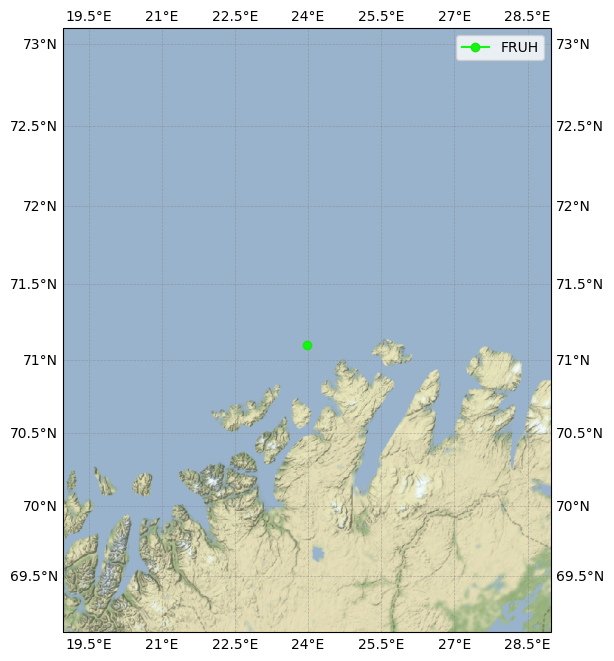

In [17]:
plt.figure(num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')
ax = plt.axes(projection=ccrs.Mercator())# Map projection
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--') #adding grid lines
for antenna in info['antennas']:
    plt.plot(antenna['lon'], antenna['lat'], color=np.random.rand(3,), markeredgecolor=np.random.rand(3,), marker='o',transform=ccrs.Geodetic(),label=antenna['name'])#add track line + profiler sampling points
if coverage:
    ax.add_geometries([coverage], crs=cartopy.crs.PlateCarree(), alpha=0.3, edgecolor='k')
ax.legend()#add legend
extent = [info['bbox'][0]-5,info['bbox'][1]+5,info['bbox'][2]-2,info['bbox'][3]+2] #minX,maxX,#minY,maxY
scale = np.ceil(-np.sqrt(2)*np.log(np.divide((extent[1]-extent[0])/2.0,350.0))) #zoom based on limits
tile_img = cimgt.StamenTerrain()
ax.add_image(tile_img,int(scale))#adding google tile
ax.set_extent(extent)#personalized limts

#uncomment next lines to save the figure
#figure_name = ds.id+'_track.png'
#plt.savefig(figure_name) 
plt.show()

#### 3.2.3. Velocity vectors

Let's plot now the map of currents (velocity vectors)!
<br>Choose first a time stamp: `set it in the next cell and run it`

In [18]:
timestamp = '2020-11-10 10:00'
datetime_obj = datetime.datetime.strptime(timestamp, '%Y-%m-%d %H:%M')

Let's calculate the closer available timestamp in the file: `tun the next cell` 

In [19]:
closerval = ds['TIME'].sel(TIME=datetime_obj, method="nearest")
idx = ds['TIME'].values.tolist().index(closerval)
print('Requested timestamp %s | Closer timestamp %s '%(timestamp,closerval.data))

Requested timestamp 2020-11-10 10:00 | Closer timestamp 2020-11-10 09:59:59.999997 


Choose also a colormap:

In [20]:
cmap = 'jet'

Choose flags to consider:

In [21]:
flags = [0,1,2,3,4,5,6,7,8,9]

Now let's plot the currents for the closest available time!: `run the next cell`

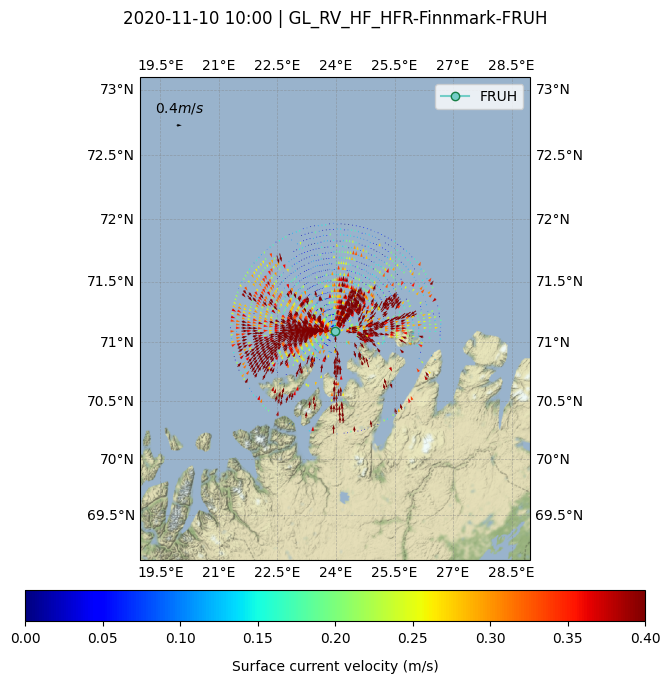

In [22]:
plt.figure(num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')
ax = plt.axes(projection=ccrs.Mercator())# Map projection
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--') #adding grid lines
#plotting antennas
for antenna in info['antennas']:
    plt.plot(antenna['lon'], antenna['lat'], color=np.random.rand(3,), markeredgecolor=np.random.rand(3,), marker='o',transform=ccrs.Geodetic(),label=antenna['name'])#add track line + profiler sampling points
ax.legend()#add legend
extent = [info['bbox'][0]-5,info['bbox'][1]+5,info['bbox'][2]-2,info['bbox'][3]+2] #minX,maxX,#minY,maxY
scale = np.ceil(-np.sqrt(2)*np.log(np.divide((extent[1]-extent[0])/2.0,350.0))) #zoom based on limits
tile_img = cimgt.StamenTerrain()
ax.add_image(tile_img,int(scale))#adding google tile
ax.set_extent(extent)#personalized limts
#quiver plot (set vectors, colormaps and colorbars)
x,y,u,v = ds['LONGITUDE'].data,ds['LATITUDE'].data,ds['EWCT'][idx,0],ds['NSCT'][idx,0]
U = u.where(ds['QCflag'][idx,0].isin(flags)).data
V = v.where(ds['QCflag'][idx,0].isin(flags)).data
m = (U ** 2 + V ** 2) ** 0.5
norm = colors.Normalize(vmin=0, vmax=0.4)
Q=ax.quiver(x, y, U,V,m,transform=cartopy.crs.PlateCarree(), cmap=cmap, norm=norm)
ax.quiverkey(Q, 0.1, 0.9, 0.4, r'$0.4 m/s$',fontproperties={'weight': 'bold'})
sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
sm._A = []
plt.colorbar(sm,ax=ax, orientation='horizontal', pad=0.05).ax.set_xlabel('Surface current velocity (m/s)', labelpad=10, )
plt.title(timestamp+' | '+ds.id, pad=25)

#uncomment next lines to save the figure
#figure_name = ds.id+'_track.png'
#plt.savefig(figure_name) 
plt.show()

#### 3.2.4. Platform performance

Performance metrics are calculated based on [MARACOOS](https://ieeexplore.ieee.org/document/6404809); which basically provides an indicator for the spatial and temporal availability of a given HF Radar with a common goal: get closer to the 80%/80% spatial and temporal availability.

Let's calculate those for the last 30 days of our HF Radar: `run the next cells`:

In [23]:
metrics = getPerformance(ds,[0,1,2,3,4,5,6,7,8,9],30)

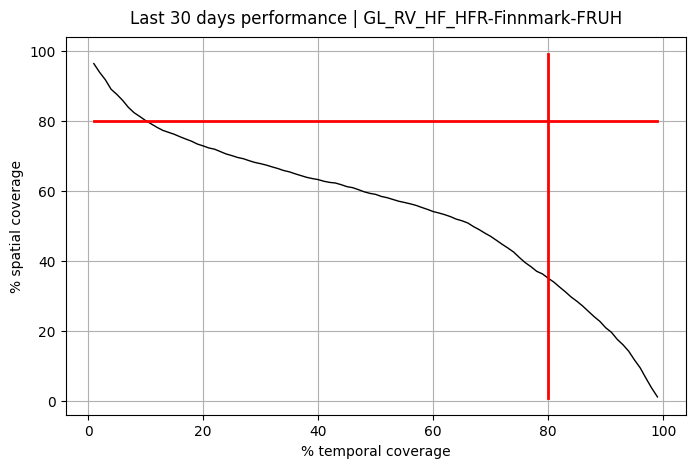

In [24]:
plt.figure(num=None, figsize=(8, 5), dpi=100, facecolor='w', edgecolor='k')
x = range(1,100,1)
ref = [80 for a in x]
if metrics:
    plt.plot(x,metrics, color = 'k', linewidth=1)
plt.plot(x,ref,color = 'r', linewidth=2)
plt.plot(ref,x,color = 'r', linewidth=2)
plt.grid(True)
plt.title('Last 30 days performance | %s'%(ds.id), pad=10)
plt.gca().set_xlabel('% temporal coverage')
plt.gca().set_ylabel('% spatial coverage')
plt.show()

## 4. Wrap-up
[Go back to the "Table of Contents"](#Table-of-Contents)

So far you should already know how to deal with gridded-like data from HF Radar platforms. <br> `If you don't please ask us! it is the moment!`